In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

from nba_api.stats.static import players, teams
from nba_api.stats.endpoints import playernextngames, playergamelog

Implement Data Collection and Data Preprocessing Functions

In [175]:
# Get player ID from name
def getPlayerID(name):
    player = players.find_players_by_full_name(name)
    return player[0]['id']

# Get team ID from name
def getTeamID(team):
    team = teams.find_team_by_abbreviation(team)
    return team[0]['id']

# Get next 5 games by player ID
def getNextGames(id):
    next = playernextngames.PlayerNextNGames(
        number_of_games="5",
        player_id=str(id),
        season_all="2023",
        season_type_all_star="Regular Season"
    )

    next_games = next.get_data_frames()[0]

    columns_to_loop = ['HOME_TEAM_ABBREVIATION', 'VISITOR_TEAM_ABBREVIATION']

    # Find player team each game
    teams = defaultdict(int)  
    for home, away in zip(next_games[columns_to_loop[0]], next_games[columns_to_loop[1]]):
        teams[home] += 1
        teams[away] += 1

    for team, amount in teams.items():
        if amount == 5:
            # Add column for player team
            next_games['PLAYER_TEAM_ABBREVIATION'] = team

    # Find opponent each game
    def findOpponent(row):
        if row['HOME_TEAM_ABBREVIATION'] == row['PLAYER_TEAM_ABBREVIATION']:
            return row['VISITOR_TEAM_ABBREVIATION']
        else:
            return row['HOME_TEAM_ABBREVIATION']
        
    # Add column for opponent
    next_games['OPPONENT_TEAM_ABBREVIATION'] = next_games.apply(findOpponent, axis=1)

    return next_games

# Get player season game log by ID
def getGameLog(id):
    stats = playergamelog.PlayerGameLog(
        player_id=str(id),
        season="2023",
        season_type_all_star="Regular Season",
        #date_from_nullable="MM/DD/YYYY"
    )

    game_log = stats.get_data_frames()[0]
    return game_log

id = getPlayerID("Lebron James")
getNextGames(id)

,GAME_ID,GAME_DATE,HOME_TEAM_ID,VISITOR_TEAM_ID,HOME_TEAM_NAME,VISITOR_TEAM_NAME,HOME_TEAM_ABBREVIATION,VISITOR_TEAM_ABBREVIATION,HOME_TEAM_NICKNAME,VISITOR_TEAM_NICKNAME,GAME_TIME,HOME_WL,VISITOR_WL,PLAYER_TEAM_ABBREVIATION,OPPONENT_TEAM_ABBREVIATION
0,0022301078,"MAR 31, 2024",1610612751,1610612747,Brooklyn,L.A. Lakers,BKN,LAL,Nets,Lakers,06:00 PM,29-45,41-33,LAL,BKN
1,0022301094,"APR 02, 2024",1610612761,1610612747,Toronto,L.A. Lakers,TOR,LAL,Raptors,Lakers,07:00 PM,23-50,41-33,LAL,TOR
2,0022301103,"APR 03, 2024",1610612764,1610612747,Washington,L.A. Lakers,WAS,LAL,Wizards,Lakers,07:00 PM,14-60,41-33,LAL,WAS
3,0022301127,"APR 06, 2024",1610612747,1610612739,L.A. Lakers,Cleveland,LAL,CLE,Lakers,Cavaliers,03:30 PM,41-33,45-29,LAL,CLE
4,0022301143,"APR 07, 2024",1610612747,1610612750,L.A. Lakers,Minnesota,LAL,MIN,Lakers,Timberwolves,10:00 PM,41-33,51-22,LAL,MIN


Implement Feature Selection

In [176]:
# Define feature variables
features = ['LOCATION', 'MIN', 'FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA']

# Define target variable
target = 'PTS'  

gamelog = getGameLog(id)

# Add game location 
gamelog['LOCATION'] = gamelog['MATCHUP'].apply(lambda x: 1 if 'vs.' in x else 0) 

X = gamelog[features]

y = gamelog[target]

Implement Model Selection & Model Training

In [177]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Selection and Training
#model = RandomForestRegressor()
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

Implement Model Evaluation and Prediction

In [178]:
upcoming = getNextGames(id)
upcoming['PREDICTED_POINTS'] = None

# Function to get the mean points scored in game logs against the opponent
def get_mean_points_for_opponent(opponent_team):
    # Filter game logs for the specific opponent team
    opponent_logs = gamelog[gamelog['MATCHUP'].str.contains(opponent_team)]

    # Calculate the mean points scored against the opponent
    mean_points = opponent_logs['PTS'].mean()
    
    return mean_points

def predict_points_against_opponent(model, opponent_team):
    # Predict points using the model
    predicted_points_model = model.predict(X)
    predicted_points = np.mean(predicted_points_model)

    # Calculate the mean points scored against the opponent
    mean_points = get_mean_points_for_opponent(opponent_team)
        
    # Weighted average prediction
    weighted_prediction = (predicted_points * 0.6) + (mean_points * 0.4)
    predictions = round(weighted_prediction)
    
    return predictions

for index, row in upcoming.iterrows():
    # Get the opponent team abbreviation
    opponent_team = row['OPPONENT_TEAM_ABBREVIATION']
    # Update predicted points for the game
    upcoming.at[index, 'PREDICTED_POINTS'] = predict_points_against_opponent(model, opponent_team)

upcoming

,GAME_ID,GAME_DATE,HOME_TEAM_ID,VISITOR_TEAM_ID,HOME_TEAM_NAME,VISITOR_TEAM_NAME,HOME_TEAM_ABBREVIATION,VISITOR_TEAM_ABBREVIATION,HOME_TEAM_NICKNAME,VISITOR_TEAM_NICKNAME,GAME_TIME,HOME_WL,VISITOR_WL,PLAYER_TEAM_ABBREVIATION,OPPONENT_TEAM_ABBREVIATION,PREDICTED_POINTS
0,0022301078,"MAR 31, 2024",1610612751,1610612747,Brooklyn,L.A. Lakers,BKN,LAL,Nets,Lakers,06:00 PM,29-45,41-33,LAL,BKN,25
1,0022301094,"APR 02, 2024",1610612761,1610612747,Toronto,L.A. Lakers,TOR,LAL,Raptors,Lakers,07:00 PM,23-50,41-33,LAL,TOR,24
2,0022301103,"APR 03, 2024",1610612764,1610612747,Washington,L.A. Lakers,WAS,LAL,Wizards,Lakers,07:00 PM,14-60,41-33,LAL,WAS,28
3,0022301127,"APR 06, 2024",1610612747,1610612739,L.A. Lakers,Cleveland,LAL,CLE,Lakers,Cavaliers,03:30 PM,41-33,45-29,LAL,CLE,24
4,0022301143,"APR 07, 2024",1610612747,1610612750,L.A. Lakers,Minnesota,LAL,MIN,Lakers,Timberwolves,10:00 PM,41-33,51-22,LAL,MIN,26


Graphing

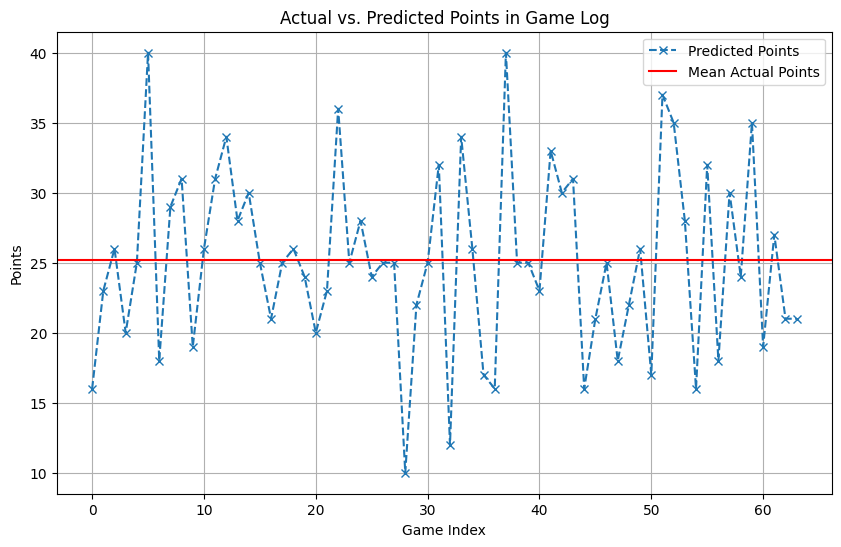

In [183]:
# Get points from gamelog
actual_points = gamelog['PTS']

# Predict points using the model
predicted_points_model = model.predict(X)

# Calculate the mean of actual points
mean_actual_points = np.mean(actual_points)

# Plot the actual and predicted points
plt.figure(figsize=(10, 6))
plt.plot(predicted_points_model, label='Predicted Points', linestyle='--', marker='x')
plt.axhline(y=mean_actual_points, color='r', linestyle='-', label='Mean Actual Points')
plt.xlabel('Game Index')
plt.ylabel('Points')
plt.title('Actual vs. Predicted Points in Game Log')
plt.legend()
plt.grid(True)
plt.show()

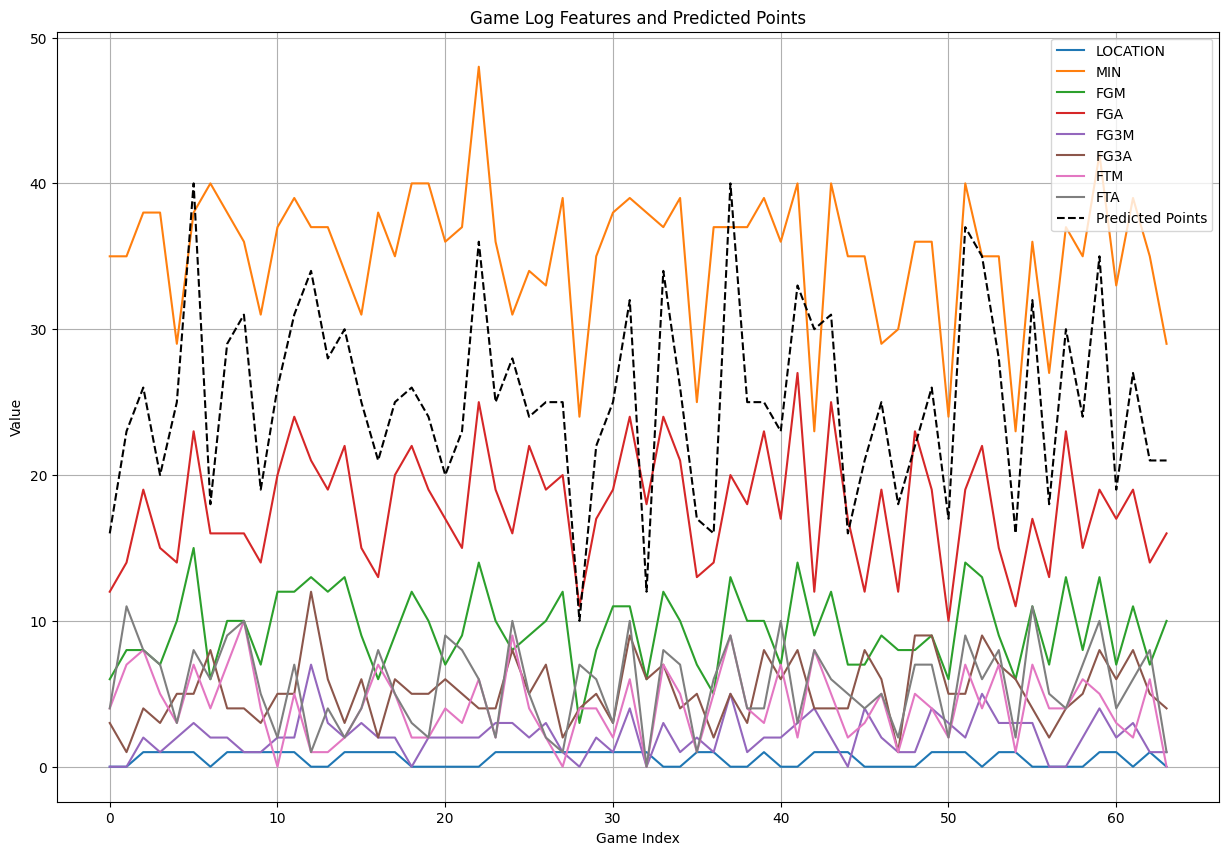

In [185]:
# Predict points using the model
predicted_points_model = model.predict(X)

# Iterate through each feature and plot it against the game index --> see comparison
plt.figure(figsize=(15, 10))
for feature in features:
    plt.plot(gamelog.index, gamelog[feature], label=feature)

# Plot predicted points
plt.plot(gamelog.index, predicted_points_model, label='Predicted Points', linestyle='--', color='black')

plt.xlabel('Game Index')
plt.ylabel('Value')
plt.title('Game Log Features and Predicted Points')
plt.legend()
plt.grid(True)
plt.show()

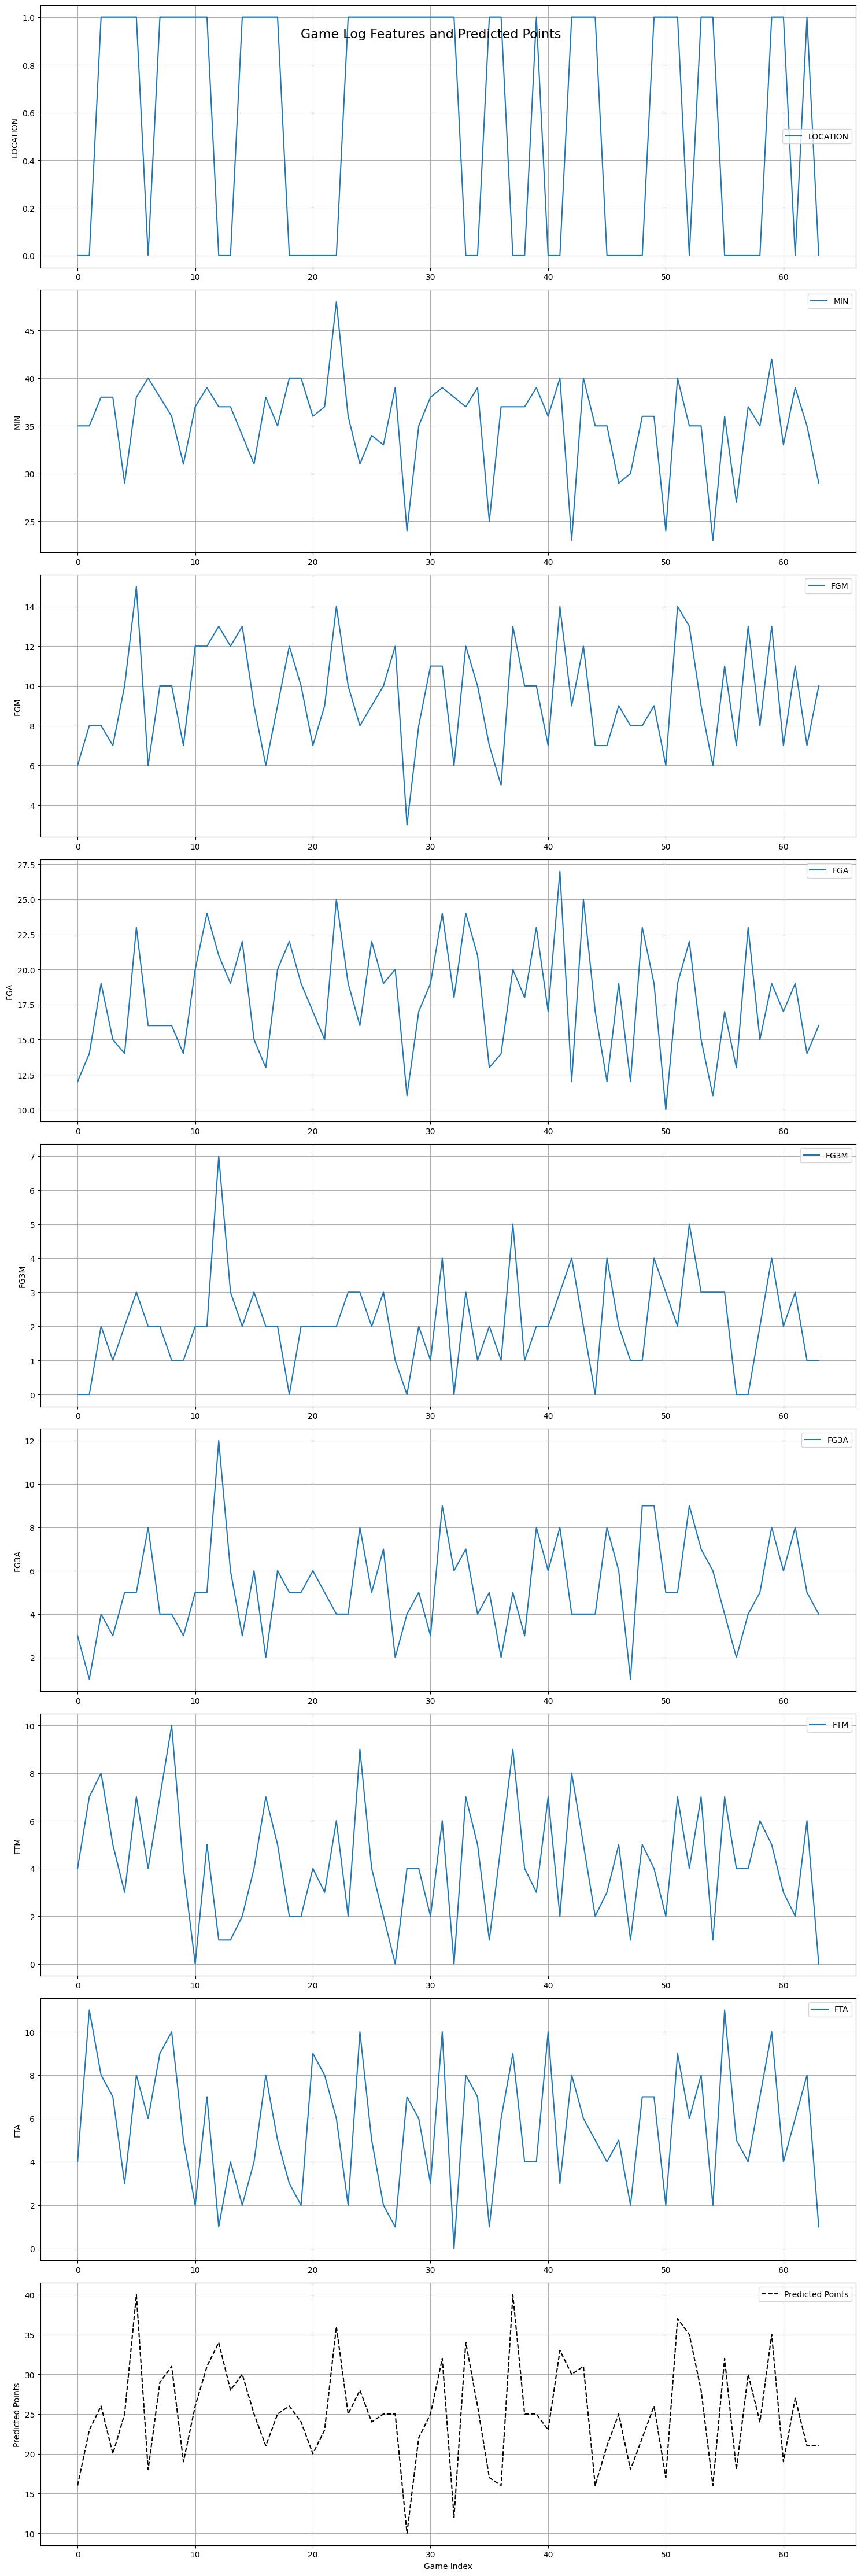

In [186]:
# Predict points using the model
predicted_points_model = model.predict(X)

# Create subplots for each feature and the predicted points
fig, axs = plt.subplots(len(features) + 1, 1, figsize=(15, 5 * (len(features) + 1)))
fig.suptitle('Game Log Features and Predicted Points', fontsize=16)

# Plot each feature
for i, feature in enumerate(features):
    axs[i].plot(gamelog.index, gamelog[feature], label=feature)
    axs[i].set_ylabel(feature)
    axs[i].grid(True)
    axs[i].legend()

# Plot predicted points
axs[len(features)].plot(gamelog.index, predicted_points_model, label='Predicted Points', linestyle='--', color='black')
axs[len(features)].set_ylabel('Predicted Points')
axs[len(features)].grid(True)
axs[len(features)].legend()

axs[len(features)].set_xlabel('Game Index')

plt.tight_layout()
plt.show()